# Imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Data

We will be creating sine wave data to test the prediction of a RNN

## Create data

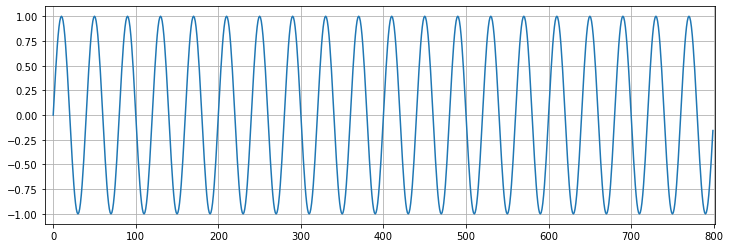

In [2]:
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*math.pi/40)

plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(x.numpy(),y.numpy())
plt.xlim(-10,801);

## Train/test split

Given that it is sequencial data, it cannot be randomly selected. We have selected a test size of 40 because the period of a sine wave is found by $\frac{2\pi}{|B|}$. Our sine function is $f(x)=\frac{2\pi x}{40}$ so our period equals $\frac{2\pi}{\frac{2\pi}{40}} = \frac{40\cdot 2\pi}{2\pi} = 40$.

In [3]:
test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

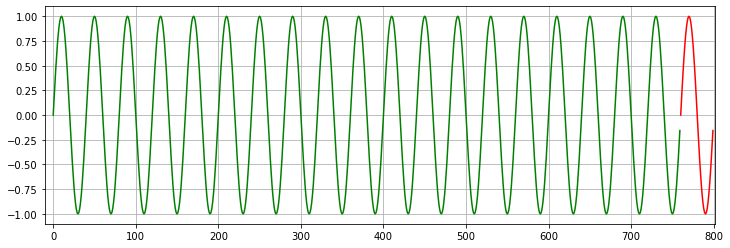

In [4]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(x.numpy()[:-test_size],train_set.numpy(),'g')
plt.plot(x.numpy()[-test_size:],test_set.numpy(),'r')
plt.xlim(-10,801);

## Prepare the training data

We need to create the windows of data that we will train with. These windows will have a sequence and a label that will be predicted. The label would be overlapping with the sequence of the next window.

For example if we have 12 observations and we are feeding size-4 windows we would have $[x_1, x_2, x_3, x_4]$ for the model to predict $x_5$. The following window would include $[x_2, x_3, x_4, x_5]$ to predict $x_6$

In [5]:
def input_data(seq, ws, l=1):
    '''
    Creates the windows of data that willb e used for training.
    '''
    out = []
    for i in range(len(seq)-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+l]
        out.append((window,label))
    return out

In [6]:
# Extract training data
window_size = 40 # One period of our sine wave
train_data = input_data(train_set,window_size)

print(f'Expected = 800 - 40(test) - 40(window) = 720\tActual = {len(train_data)}')

Expected = 800 - 40(test) - 40(window) = 720	Actual = 720


# Define an LSTM model

The model will have an LSTM layer with with a single input and 50 hidden layers. The layers will expand the input to the number of layers, these will then need to be consolidated to output a single output through a fully-connected layer.

During the training, we will be passing three tensors to the LSTM layer:
1. Sequence
2. Hidden state $h_0$
3. Cell state $c_0$

The hidden $h_0$ and cell $c_0$ state tensors have to be initialised. This can be done with random values or zeroes.

When creating the forward pass the LSTM layer will output the LSTM output + hidden and cell states. These will then need to be updated on the forward pass.

The LSTM layer expects an input of size `input, (h_0,c_0)`

In [7]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=50,out_size=1):
        
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer
        self.lstm = nn.LSTM(input_size,hidden_size) 
        
        # Add a fully-connected layer
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

## Instantiate the model, define loss & optimisation functions

In [8]:
torch.manual_seed(42)
model = LSTM()

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),0.01)
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
# Number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   200
 10000
   200
   200
    50
     1
______
 10651


# Train and evaluation

Initially we will train on the train dataset and evaluate on the test dataset. Once we have successfully trained and evaluated, we will be retraining on all available data and forecasting beyond the scope of the original data.

Epoch 0  Loss: 0.09209898859262466
Loss on test predictions: 0.6073052287101746


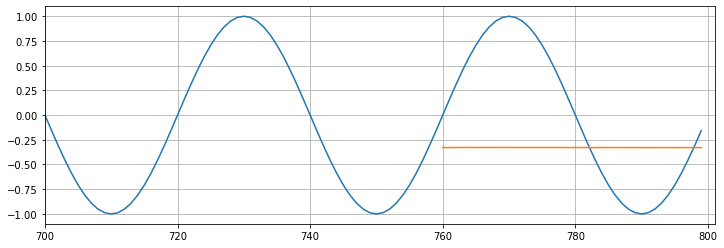

Epoch 1  Loss: 0.06505247950553894
Loss on test predictions: 0.5652278661727905


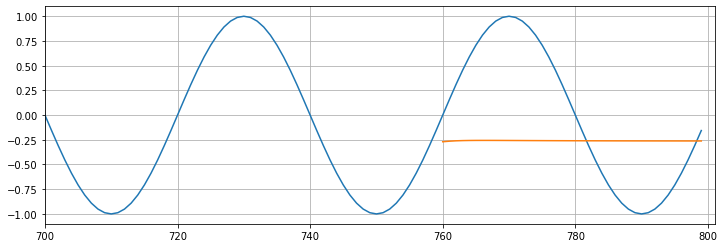

Epoch 2  Loss: 0.04197339713573456
Loss on test predictions: 0.5200702548027039


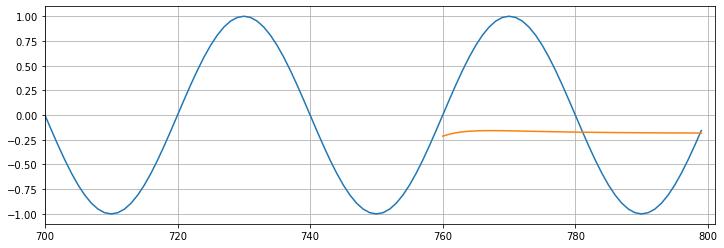

Epoch 3  Loss: 0.017842350527644157
Loss on test predictions: 0.4221588969230652


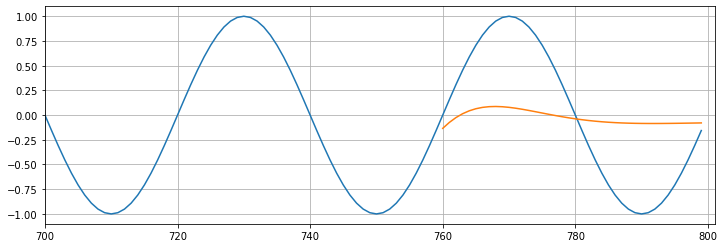

Epoch 4  Loss: 0.0028890506364405155
Loss on test predictions: 0.16624265909194946


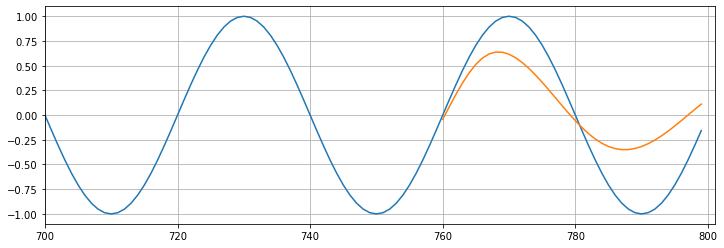

Epoch 5  Loss: 0.0003210682771168649
Loss on test predictions: 0.030550945550203323


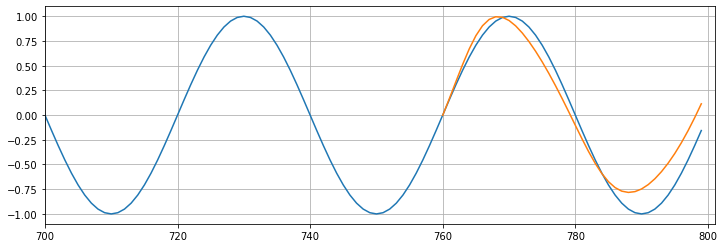

Epoch 6  Loss: 0.00013034758740104735
Loss on test predictions: 0.014989654533565044


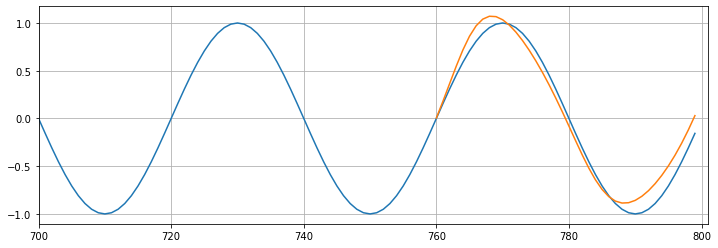

Epoch 7  Loss: 0.00012068532669218257
Loss on test predictions: 0.011856269091367722


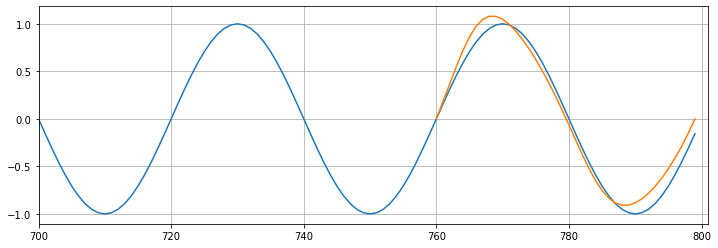

Epoch 8  Loss: 0.0001271718501811847
Loss on test predictions: 0.010163581930100918


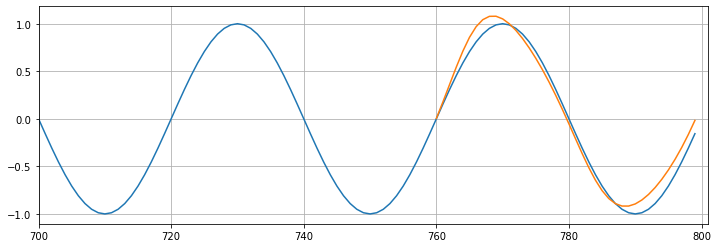

Epoch 9  Loss: 0.00013256551756057888
Loss on test predictions: 0.008897272869944572


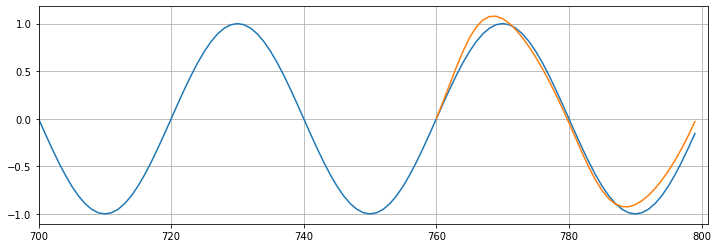

In [10]:
epochs = 10
future = 40

for i in range(epochs):
    
    # Retreive the training dataset
    for seq, y_train in train_data:
        
        # Reset the parameters and hidden states
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # Predictions
        y_pred = model(seq)
        
        # Calculate loss and propagate
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimiser.step()
    
    # Print training result
    print(f'Epoch {i}  Loss: {loss.item()}')
    
    # MAKE PREDICTIONS
    # Grabbing the last window of the training set (from end - 40) and predict the first value of the test set
    preds = train_set[-window_size:].tolist()
    
    # Get the predictions for the future range = 40 points
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    # Calculate the loss and compare the prediction to the real data
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')
    
    # Plot the sine curve
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

# Forecast into future

In [11]:
epochs = 10
window_size = 40
future = 40

all_data = input_data(y, window_size)
len(all_data)

760

In [12]:
import time
start_time = time.time()

for i in range(epochs):
    
    # Get data
    for seq, y_train in all_data:
        
        # Reset the parameters and hidden states
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # Predict
        y_pred = model(seq)
        
        # Loss and backpropagation
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimiser.step()
        
    # Print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00013519
Epoch:  2 Loss: 0.00013508
Epoch:  3 Loss: 0.00013294
Epoch:  4 Loss: 0.00012940
Epoch:  5 Loss: 0.00012492
Epoch:  6 Loss: 0.00011987
Epoch:  7 Loss: 0.00011451
Epoch:  8 Loss: 0.00010905
Epoch:  9 Loss: 0.00010362
Epoch: 10 Loss: 0.00009831

Duration: 28 seconds


# Forecast

In [13]:
preds = y[-window_size:].tolist()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        
        # Append prediction to the pred list
        preds.append(model(seq).item())

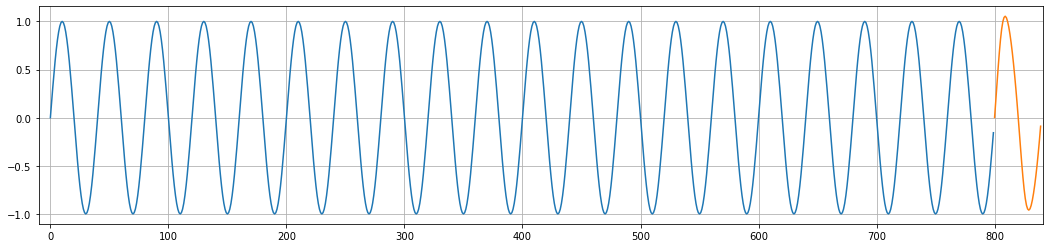

In [15]:
plt.figure(figsize=(18,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())

# Plotting the forecast
plt.plot(range(800,800+future),preds[window_size:])
plt.show()

# EXTRA: Adding hidden layers

In [18]:
torch.manual_seed(42)
model = LSTM(hidden_size=100)

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(),0.01)
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

Epoch 0  Loss: 0.07569044828414917
Loss on test predictions: 0.5811928510665894


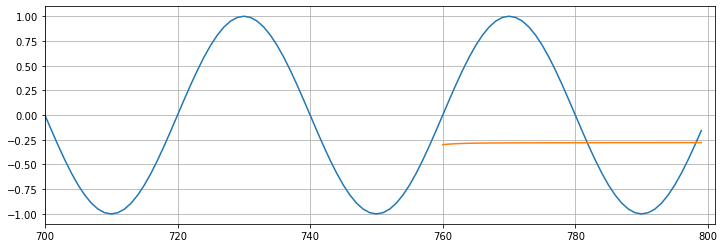

Epoch 1  Loss: 0.046044256538152695
Loss on test predictions: 0.5293501615524292


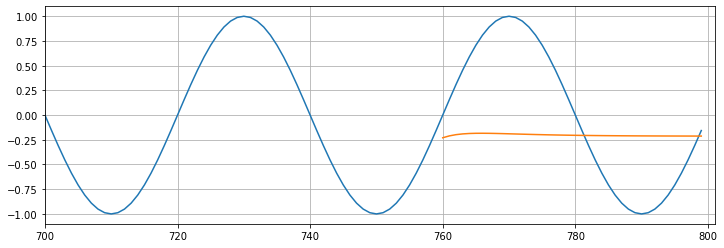

Epoch 2  Loss: 0.01740172505378723
Loss on test predictions: 0.4292145371437073


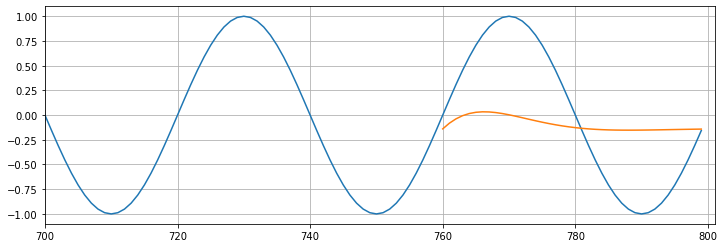

Epoch 3  Loss: 0.001725411624647677
Loss on test predictions: 0.1779489815235138


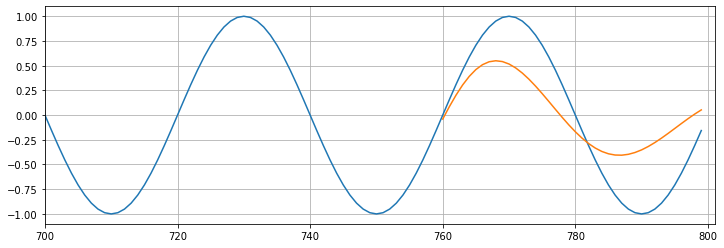

Epoch 4  Loss: 2.8049265893059783e-05
Loss on test predictions: 0.014113766141235828


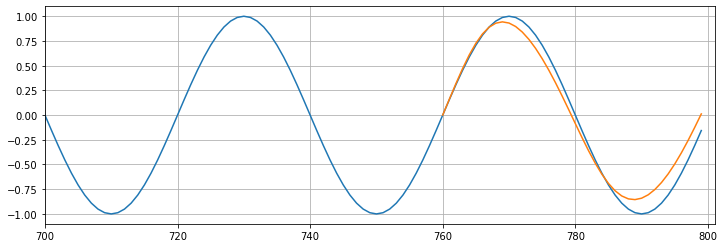

Epoch 5  Loss: 2.3377029378934822e-07
Loss on test predictions: 0.0022927087265998125


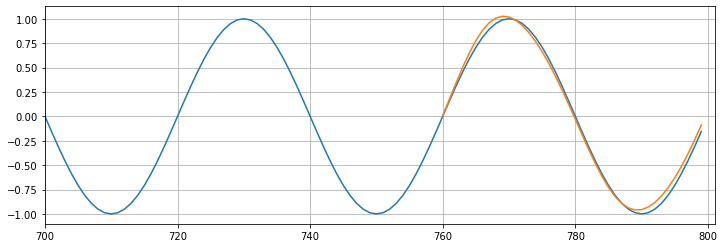

Epoch 6  Loss: 8.336671726283384e-07
Loss on test predictions: 0.0017020389204844832


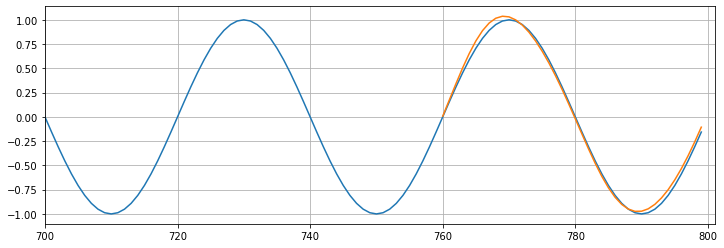

Epoch 7  Loss: 4.582543340347911e-07
Loss on test predictions: 0.0015901324804872274


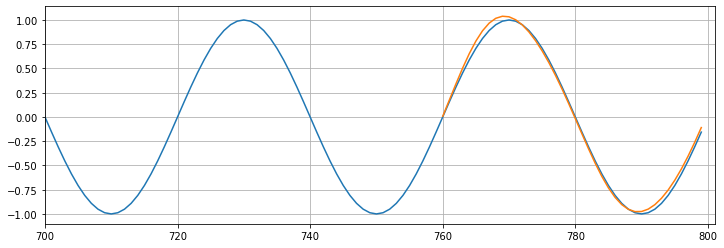

Epoch 8  Loss: 1.465783583398661e-07
Loss on test predictions: 0.0015220879577100277


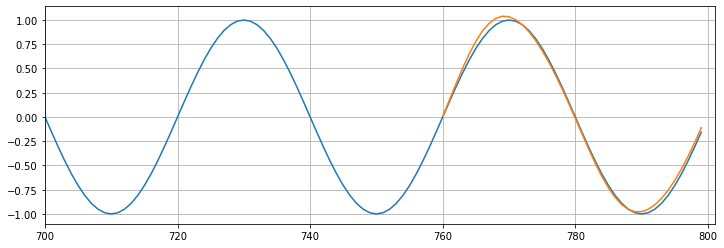

Epoch 9  Loss: 1.0793318239166183e-08
Loss on test predictions: 0.0014634019462391734


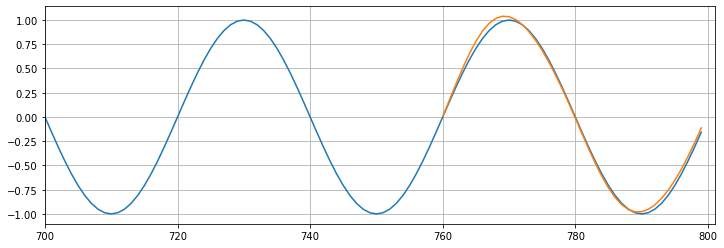

Epoch 10  Loss: 2.3305807062001804e-08
Loss on test predictions: 0.0014097766252234578


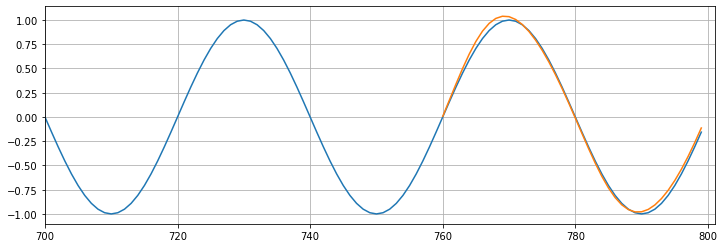

Epoch 11  Loss: 1.5009061371529242e-07
Loss on test predictions: 0.0013604515697807074


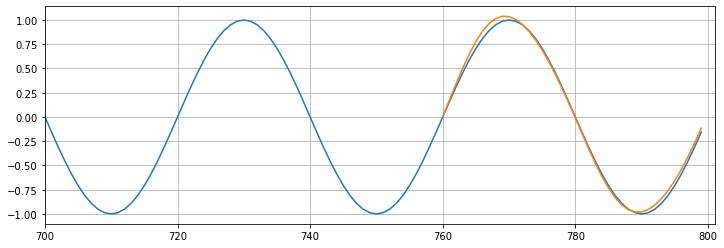

Epoch 12  Loss: 3.6217912224856263e-07
Loss on test predictions: 0.0013148197904229164


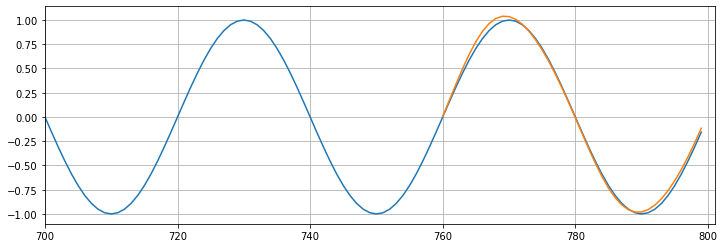

Epoch 13  Loss: 6.36188815406058e-07
Loss on test predictions: 0.0012725936248898506


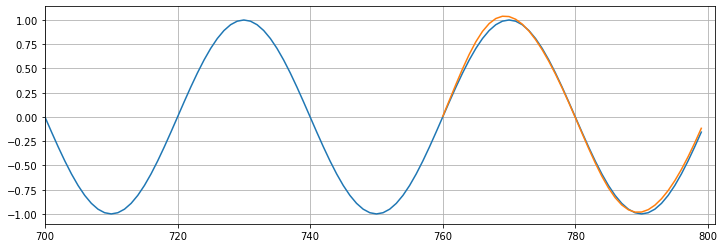

Epoch 14  Loss: 9.525105042484938e-07
Loss on test predictions: 0.0012334247585386038


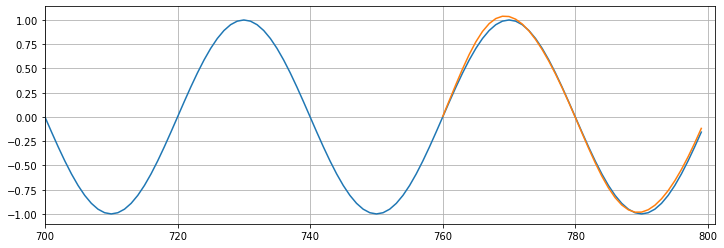

Epoch 15  Loss: 1.2961332913619117e-06
Loss on test predictions: 0.0011969152837991714


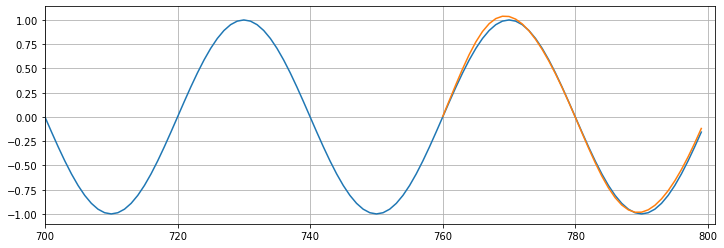

Epoch 16  Loss: 1.6544092886761064e-06
Loss on test predictions: 0.0011629587970674038


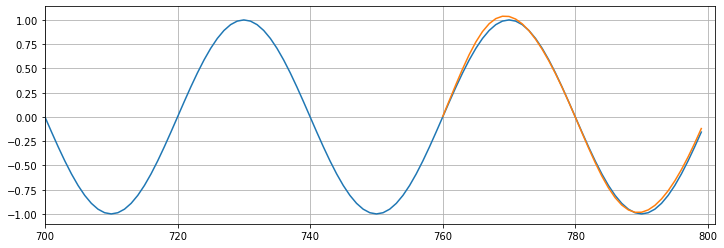

Epoch 17  Loss: 2.017475708271377e-06
Loss on test predictions: 0.0011312153656035662


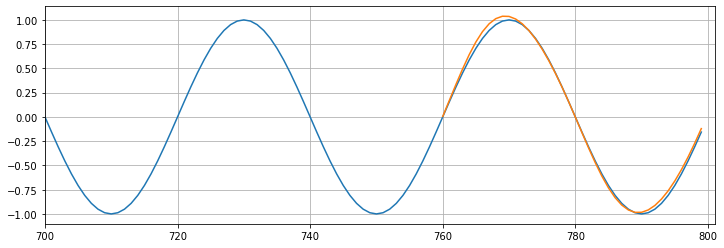

Epoch 18  Loss: 2.377862074354198e-06
Loss on test predictions: 0.001101499074138701


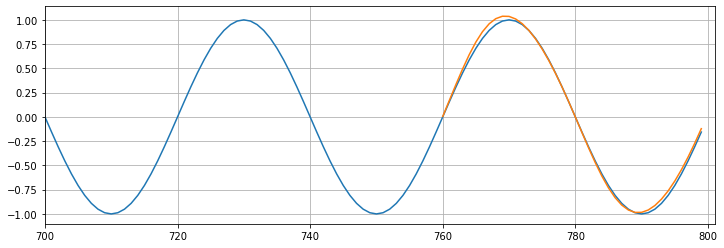

Epoch 19  Loss: 2.72945635515498e-06
Loss on test predictions: 0.0010736588155850768


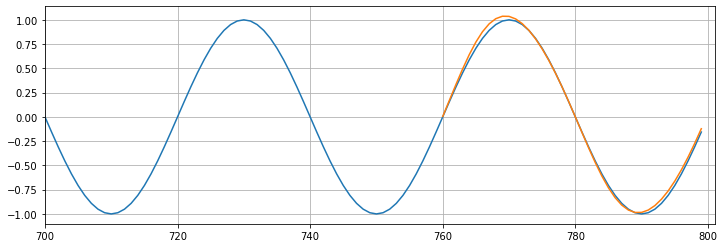

In [19]:
epochs = 20
future = 40

for i in range(epochs):
    
    # Retreive the training dataset
    for seq, y_train in train_data:
        
        # Reset the parameters and hidden states
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # Predictions
        y_pred = model(seq)
        
        # Calculate loss and propagate
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimiser.step()
    
    # Print training result
    print(f'Epoch {i}  Loss: {loss.item()}')
    
    # MAKE PREDICTIONS
    # Grabbing the last window of the training set (from end - 40) and predict the first value of the test set
    preds = train_set[-window_size:].tolist()
    
    # Get the predictions for the future range = 40 points
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    # Calculate the loss and compare the prediction to the real data
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')
    
    # Plot the sine curve
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()